<a href="https://colab.research.google.com/github/soorajpu12/LSTproject/blob/master/LST_from_emmisivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rasterio code snippets taken from- https://geohackweek.github.io/raster/04-workingwithrasters/

**References**

1) Land Surface Temperature Retrieval from Landsat 8
TIRS—Comparison between Radiative Transfer
Equation-Based Method, Split Window Algorithm
and Single Channel Method by Xiaolei Yu 1,*, Xulin Guo 1 and Zhaocong Wu 2

2) Land surface temperature retrieval from LANDSAT TM 5 by
Jose´ A. Sobrinoa,*, Juan C. Jimenez-Munoza, Leonardo Paolinib

3) A mono-window algorithm for retrieving land surface temperature
from Landsat TM data and its application to the Israel-Egypt border
region by Z. QIN*, A. KARNIELI†

In [1]:
pip install rasterio

In [2]:
pip install pyproj

In [3]:
import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [4]:
%pylab inline
pylab.rcParams['figure.figsize'] = (13, 13)

Populating the interactive namespace from numpy and matplotlib


1) CONVERSION TO **TOA BRIGHTNESS TEMPERATURE**

Decimation factor= 9


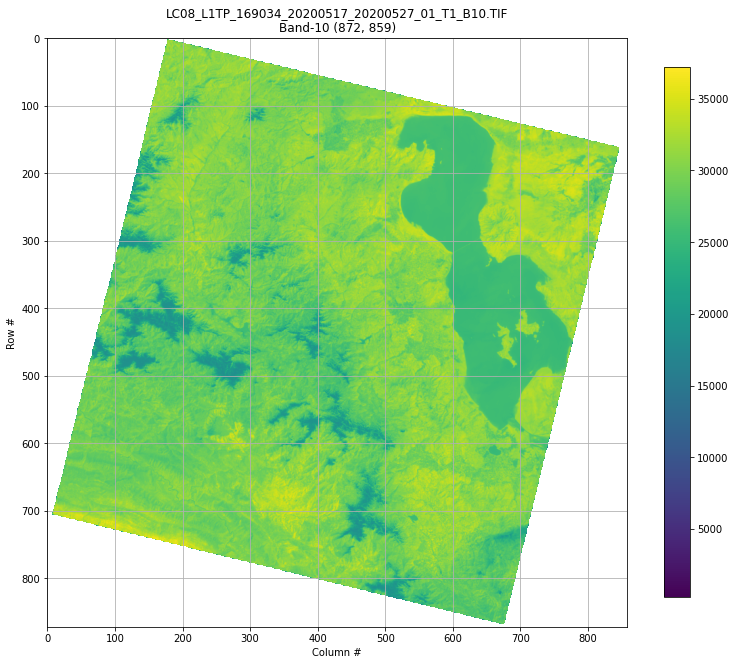

In [5]:
# Upload band 10 to get brightness temperature

date = '2020-05-17'
url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/169/034/LC08_L1TP_169034_20200517_20200527_01_T1/'
dn_band = 'LC08_L1TP_169034_20200517_20200527_01_T1_B{}.TIF'.format(10)

with rasterio.open(url+dn_band) as src1:
    profile = src1.profile
    oviews = src1.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    dnn = src1.read(1, out_shape=(1, int(src1.height // oview), int(src1.width // oview)))
    #############################################
    # remove border
    dnnb = dnn.astype('f4')
    dnnb[dnnb==0] = np.nan
    #############################################

plt.imshow(dnnb)
plt.colorbar(shrink=0.75)
plt.title('{}\nBand-10 {}'.format(dn_band, dnn.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')
matplotlib.pyplot.grid()

In [6]:
# define brightness temperature function

def DN_to_BrightnessTemp(image, M , A , k1, k2):     
    
    TOA_radiance = np.zeros(image.shape)
    brightness_temp = np.zeros(image.shape)        
    TOA_radiance = (M * image) + A
    # The minus 273.15 below is so as to obtain the result in degree celcius
    brightness_temp = (k2 / (np.log((k1 / TOA_radiance) + 1))) - 273.15
    return brightness_temp

OLI and TIRS band data can be converted to TOA Spectral Radiance using Radiance rescaling factors in the metadata file

[TXT FILE URL](http://landsat-pds.s3.amazonaws.com/c1/L8/169/034/LC08_L1TP_169034_20200517_20200527_01_T1/LC08_L1TP_169034_20200517_20200527_01_T1_MTL.txt)


    # M = Band-specific multiplicative rescaling factor from the image folder metadata (RADIANCE_MULT_BAND_x, where x is the band number).
    # A = Band-specific additive rescaling factor from the image folder metadata (RADIANCE_ADD_BAND_x, where x is the band number).
    # k1 = Band-specific thermal conversion constant from the image folder metadata (K1_CONSTANT_BAND_x, where x is the thermal band number)
    # k2 = Band-specific thermal conversion constant from the image folder metadata (K2_CONSTANT_BAND_x, where x is the thermal band number

In [7]:
# input values manually from MTL.txt file

image = dnnb
M = 3.3420E-04
A = 0.10000
k1 = 774.8853 
k2 = 1321.0789

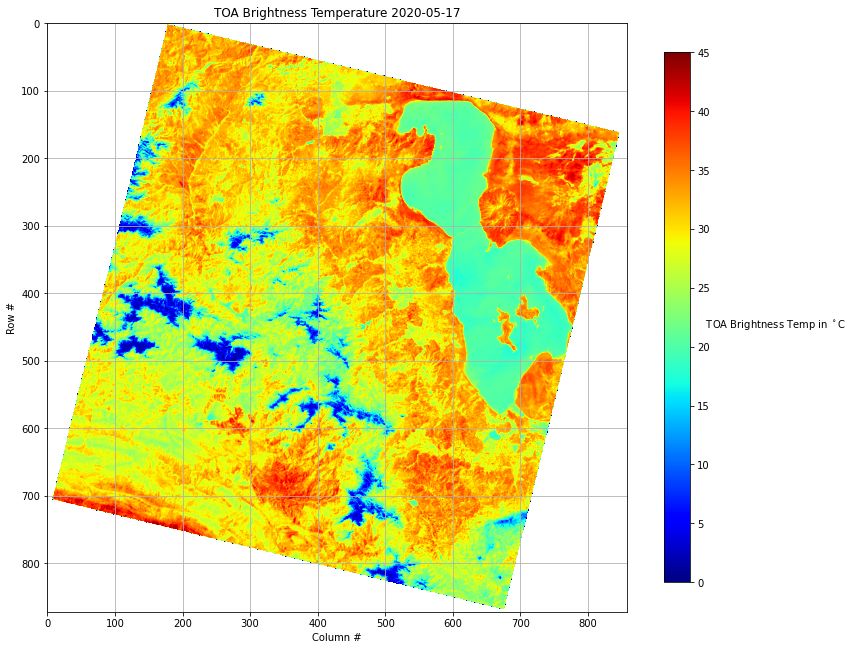

In [8]:
# call the brightness temperature function

dn1 = DN_to_BrightnessTemp(image, M , A , k1, k2)
dn1 = dn1.astype('f4')
dn1[dn1==0] = np.nan
plt.imshow(dn1, cmap='jet')
plt.title('TOA Brightness Temperature {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')
matplotlib.pyplot.grid()
plt.clim(0,45)
ab= plt.colorbar(shrink=0.75)
ab.set_label('                                       TOA Brightness Temp in $^\circ$C', rotation=0)

2) FINDING **NDVI**

Decimation factor= 9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


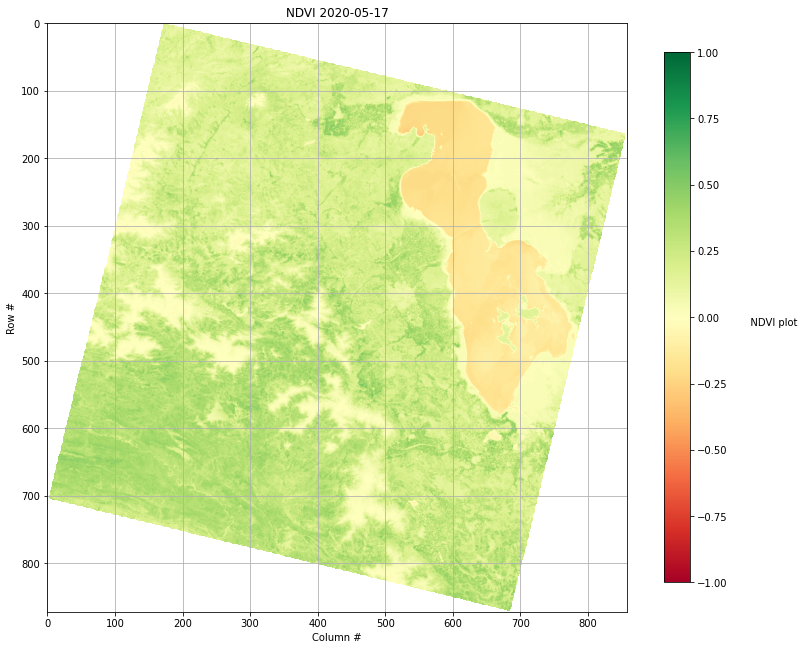

In [9]:
# use redband and nirband to find NDVI 

date = '2020-05-17'
url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/169/034/LC08_L1TP_169034_20200517_20200527_01_T1/'
redband = 'LC08_L1TP_169034_20200517_20200527_01_T1_B{}.TIF'.format(4)
nirband = 'LC08_L1TP_169034_20200517_20200527_01_T1_B{}.TIF'.format(5)

#######################################################################################

with rasterio.open(url+redband) as src:
    profile = src.profile
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    red = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

#######################################################################################

with rasterio.open(url+nirband) as src:
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    nir = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

#######################################################################################

# define the NDVI function

def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi

# call the NDVI function    

ndvi = calc_ndvi(nir,red)

# plot the NDVI image

plt.imshow(ndvi, cmap='RdYlGn')
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')
matplotlib.pyplot.grid()
plt.clim(-1,1)
ab= plt.colorbar(shrink=0.75)
ab.set_label('                           NDVI plot', rotation=0)

3) FINDING **EMISSIVITY**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  


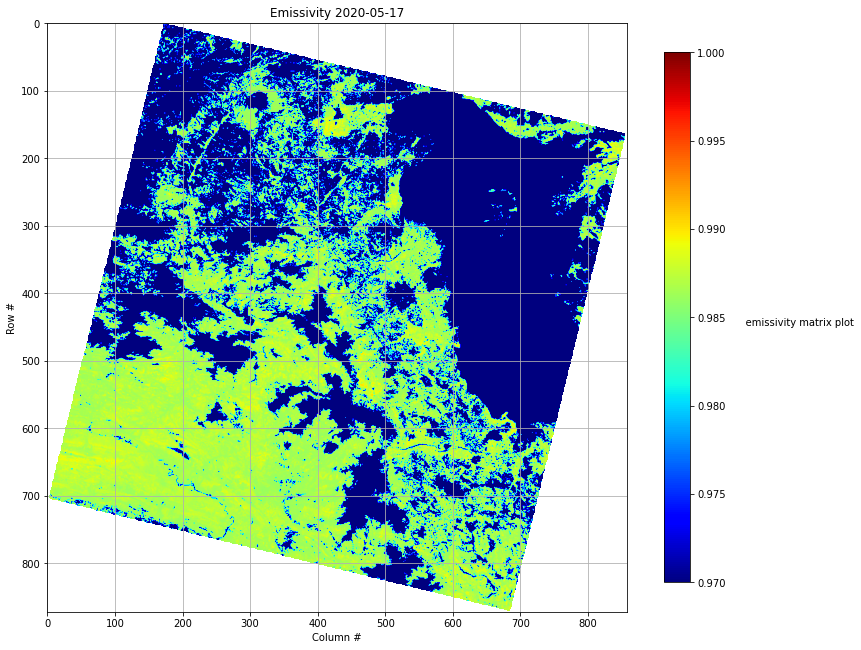

In [10]:
# define emissivity function

def emmissivity_NDVI_threshold_TIR10(NDVI, mask):
        emissivity = np.zeros(NDVI.shape) 
        # Set values in emissivity matrix based on NDVI matrix value with same index
        type1 = NDVI < 0.2
        type2 = NDVI > 0.5
        type3 = (NDVI >= 0.2) & (NDVI <= 0.5)

        i1, j1 = np.where(type1)
        emissivity[i1, j1] = 0.97
        i2, j2 = np.where(type2)
        emissivity[i2, j2] =  0.99 
        i3, j3 = np.where(type3)
        emissivity[i3, j3] = (0.004*(((NDVI[i3, j3] - 0.2)/(0.5 - 0.2))**2)) + 0.986
        return emissivity

# call the emissivity function

emm1 = emmissivity_NDVI_threshold_TIR10(ndvi, None)     

# plot the emissivity image

############################################# 
emm1 = emm1.astype('f4')
emm1[emm1==0] = np.nan
#############################################
plt.imshow(emm1, cmap='jet')
plt.title('Emissivity {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')
matplotlib.pyplot.grid()
plt.clim(0.97,1)
ab= plt.colorbar(shrink=0.75)
ab.set_label('                                             emissivity matrix plot', rotation=0)

4) FINDING **LAND SURFACE TEMPERATURE**

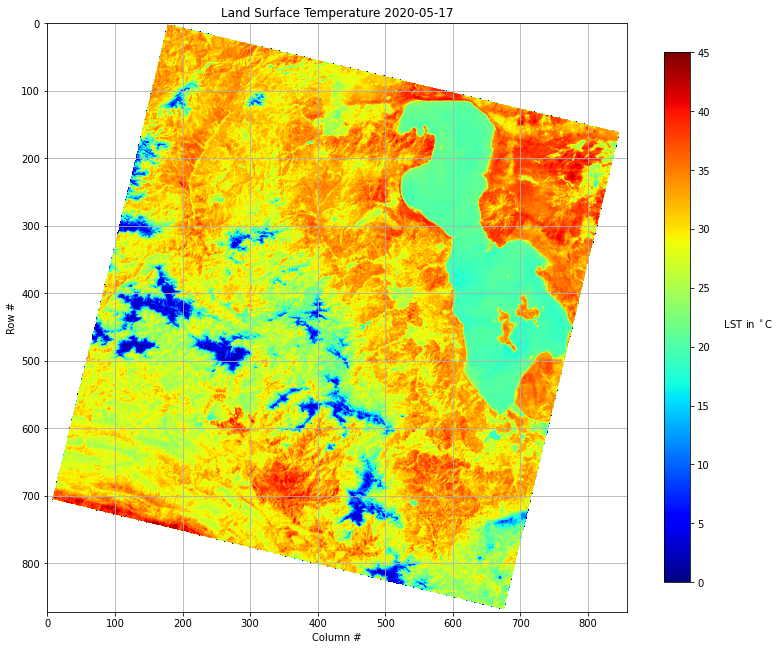

In [11]:
# define the LST function

def compute_LST(TOA, emissivity):       
    
    land_surface_temp = TOA / (1 + (((0.0000115 * TOA) / 14380) * np.log(emissivity)))
    return land_surface_temp

# call the LST function    

lstm = compute_LST(dn1, emm1)

# plot the LST image

#############################################
lstm = lstm.astype('f4')
lstm[lstm==0] = np.nan
#############################################
plt.imshow(lstm, cmap='jet')
plt.title('Land Surface Temperature {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')
matplotlib.pyplot.grid()
plt.clim(0,45)
ab= plt.colorbar(shrink=0.75)
ab.set_label('                      LST in $^\circ$C', rotation=0)